In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

# Force reload of project files
import data, train, models, evaluate, metrics
importlib.reload(data)
from data import TAPDataLoader

data_dir = Path("../data/wqp")
basin_list_file = data_dir / "metadata" / "site_lists" / "sites_all.txt"
# basin_list_file = data_dir / "metadata" / "site_lists" / "sites_ssc_area1000_n10.txt"
sequence_length = 30
batch_size = 16

with open(basin_list_file, 'r') as file:
    basin_list = file.readlines()
    basin_list = [basin.strip() for basin in basin_list]

data_params = {'data_dir': data_dir,
               'basin_list': basin_list,
               'features_dict': {'daily':['grfr_q'],
                                 'irregular':['Blue','Green','Red','Nir','Swir1','Swir2']},
               'target': 'turbidity',
               'time_slice': slice('1979-01-01', '2018-12-31'),
               'split_time': np.datetime64('2010-01-01'),
               'train': True,
               'batch_size': batch_size,
               'sequence_length': sequence_length,
               'log_norm_cols': ['turbidity'],
               'discharge_col': 'grfr_q',
               'num_workers':1}

dataloader = TAPDataLoader(**data_params)

Loading Basins:   0%|          | 0/1867 [00:00<?, ?it/s]

Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


Output()

Training finished or interrupted. Model state saved.


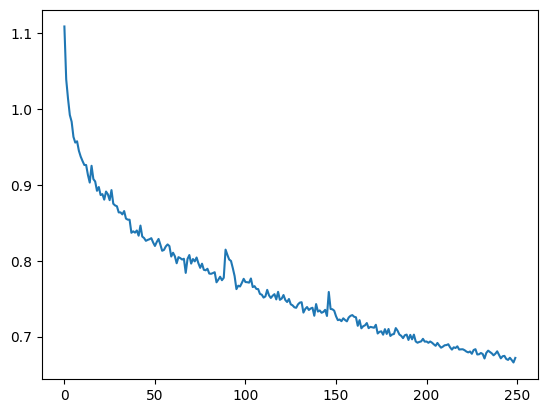

In [2]:
importlib.reload(models)
importlib.reload(train)
from models import ANN, HybridModel, TAPLSTM, EALSTM, LSTM
from train import Trainer


daily_in_size = len(data_params['features_dict']['daily'])
irregular_in_size = len(data_params['features_dict']['irregular'])
static_in_size = dataloader.dataset.x_s[basin_list[0]].shape[0]
output_size = 1
hidden_size = 256
dropout = 0.4
key = jax.random.PRNGKey(0)

num_epochs = 250
# lr_schedule = optax.polynomial_schedule(0.01, 0.0001, 2, num_epochs)
lr_schedule = optax.exponential_decay(0.01, num_epochs, 0.3)

model_args = {'dynamic_in_size': irregular_in_size+daily_in_size, 
              'dynamic_hidden_size': 64, 
              'num_dynamic_layers': 4,
              'static_in_size': static_in_size,
              'static_hidden_size': 8,
              'num_static_layers': 2,
              'output_size': 1,
              'key': jax.random.PRNGKey(0), 
              'dropout': 0.2}

ann = ANN(**model_args)
# model = HybridModel((irregular_in_size, hidden_size, hidden_size, output_size), daily_in_size, static_in_size, output_size, hidden_size, key=key, dropout=dropout)

dataloader.set_mode(train=True, sequence=False, end2end=False)
trainer = Trainer(ann, dataloader, lr_schedule, num_epochs, max_grad_norm=2)
model = trainer.start_training()


Output()

Training finished or interrupted. Model state saved.


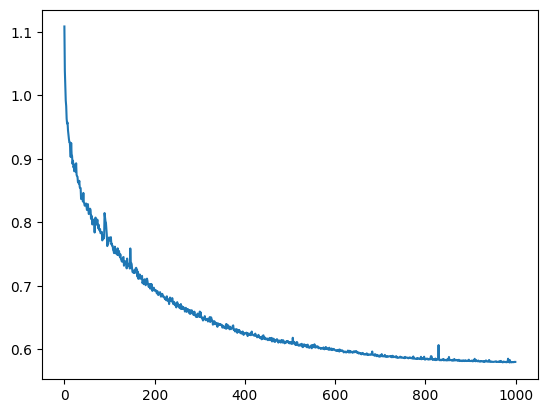

In [3]:
trainer.num_epochs=1000
model = trainer.start_training()

In [4]:
from metrics import get_all_metrics

importlib.reload(evaluate)
from evaluate import predict

#Need a sr evaluate mode. Maybe just rethink the entire indexing scheme.
dataloader.set_mode(train=False, sequence=False)
results = predict(ann, dataloader)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0
metrics = get_all_metrics(results['obs'],results['pred'])
metrics

  0%|          | 0/356 [00:00<?, ?it/s]

{'mse': 63332.285,
 'rmse': 251.65907,
 'kge': -0.5262250695583015,
 'nse': -919053.0}

In [10]:
results

,,obs,pred
basin,date,,
7120640640,2009-02-02,8.400000,10.815063
7120676550,2004-01-28,10.000001,10.821022
7120522040,2005-03-16,15.999999,10.690677
7120641700,2004-05-05,18.000002,10.722279
7120640980,1999-10-14,65.400009,10.680709
...,...,...,...
7120653990,1999-11-08,5.100001,10.753312
7120568540,2006-06-29,122.000031,10.956944
7120456910,1996-03-28,240.000031,11.044060


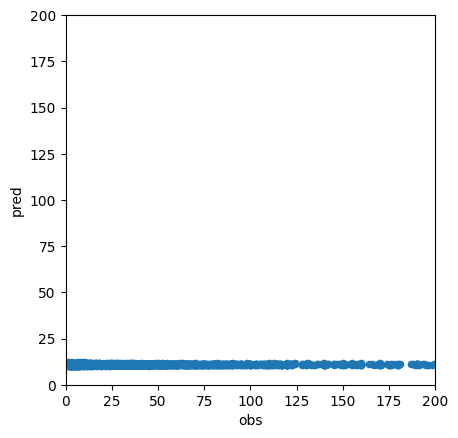

In [6]:
results.plot.scatter('obs','pred')
plt.gca().set_aspect('equal')
plt.xlim([0,200])
plt.ylim([0,200])
plt.show()

In [ ]:
for _, _, batch in dataloader:
    break
jax.vmap(ann)(batch)

In [ ]:
dataloader.set_mode(train=True, sequence=False, end2end=False)
x = []
for _, _, batch in tqdm(dataloader):
    x.extend(batch['y'])
# x = np.array(x).flatten()
# x = dataloader.dataset.denormalize_target(x)
# plt.hist(x)

In [ ]:
batch['x_s'].shape

In [ ]:
xt = np.array(x).flatten()
# xt = dataloader.dataset.denormalize_target(xt)
plt.hist(xt)

In [ ]:
dataloader.dataset.scale